In [ ]:
import pandas as pd
import boto3
import io
import os
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

## Data Gathering

The data utilized is stored in an s3 bucket. The credentials are being passed as environment variables set on my computer.

In [167]:
load_dotenv()
bucket_name = "rearc-test-bucket-52b4815e"
bls_file = "bls_data/pr.data.0.Current"
population_data = "datausa/datausa_population.json"

In [168]:
AWS_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

In [169]:
def trim_whitespace_from_df(df: pd.DataFrame) -> pd.DataFrame:
    """Trims whitespace from column names and string values in a DataFrame.

    Args:
        df (pd.DataFrame): Pandas Dataframe from which to trim whitespace.

    Returns:
        pd.DataFrame: Cleaned Pandas DataFrame with whitespace removed from column names and string values.
    """
    try:
        df.columns = df.columns.str.strip()
        df = df.map(lambda x: x.strip() if isinstance(x, str) else x)
        return df
    except TypeError as e:
        print(f"Data passed was not a DataFrame: {e}")
        return df

In [170]:
s3 = boto3.client("s3", aws_access_key_id=AWS_ACCESS_KEY, aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
bls_csv = s3.get_object(Bucket=bucket_name, Key=bls_file)
population_json = s3.get_object(Bucket=bucket_name, Key=population_data)

In [171]:
bls_data = bls_csv["Body"].read().decode("utf-8")
bls_df = pd.read_csv(io.StringIO(bls_data), sep='\t')
bls_df = trim_whitespace_from_df(bls_df)
bls_df.columns = bls_df.columns.str.capitalize()
bls_df.head()

,Series_id,Year,Period,Value,Footnote_codes
0,PRS30006011,1995,Q01,2.6,NaN
1,PRS30006011,1995,Q02,2.1,NaN
2,PRS30006011,1995,Q03,0.9,NaN
3,PRS30006011,1995,Q04,0.1,NaN
4,PRS30006011,1995,Q05,1.4,NaN


In [172]:
population_data = json.loads(population_json["Body"].read().decode("utf-8"))
population_df = pd.json_normalize(population_data, record_path=['data'])
population_df = trim_whitespace_from_df(population_df)
population_df["Population"] = population_df["Population"].astype(int)
population_df.head(10)

,Nation ID,Nation,Year,Population
0,01000US,United States,2013,316128839
1,01000US,United States,2014,318857056
2,01000US,United States,2015,321418821
3,01000US,United States,2016,323127515
4,01000US,United States,2017,325719178
5,01000US,United States,2018,327167439
6,01000US,United States,2019,328239523
7,01000US,United States,2021,331893745
8,01000US,United States,2022,333287562
9,01000US,United States,2023,334914896


In [173]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Nation ID   10 non-null     object
 1   Nation      10 non-null     object
 2   Year        10 non-null     int64 
 3   Population  10 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 452.0+ bytes


## Population Mean and Standard Deviation

The mean and standard deviation of the US population from years 2013-2018, inclusive, based on data from Datausa.io.

In [174]:
filtered_population_df = population_df[(population_df["Year"] >= 2013) & (population_df["Year"] <= 2018)]
mean_population = filtered_population_df["Population"].mean()
standard_deviation = filtered_population_df["Population"].std()
print(f"Mean Population (2013-2018): {int(mean_population):,}")
print(f"Standard Deviation (2013-2018): {int(standard_deviation):,}")

Mean Population (2013-2018): 322,069,808
Standard Deviation (2013-2018): 4,158,441


In [175]:
series_id_list = bls_df["Series_id"].unique().tolist()
print(f"Number of unique series IDs: {len(series_id_list)}")

Number of unique series IDs: 282


In [176]:
series_grouped = bls_df.groupby(["Series_id", "Year"])["Value"].sum()
series_grouped = series_grouped.reset_index()

In [177]:
best_years_idx = series_grouped.groupby("Series_id")["Value"].idxmax()
best_years_for_each_series = series_grouped.loc[best_years_idx, ["Series_id", "Year", "Value"]]

## Best Year For Each Series

Identifying the best year for each series in the BLS data was accomplished by grouping the BLS data by series_id and year. The sum for each year was determined, listing a single row for each series and year. The max value was then identified to generate the below table.

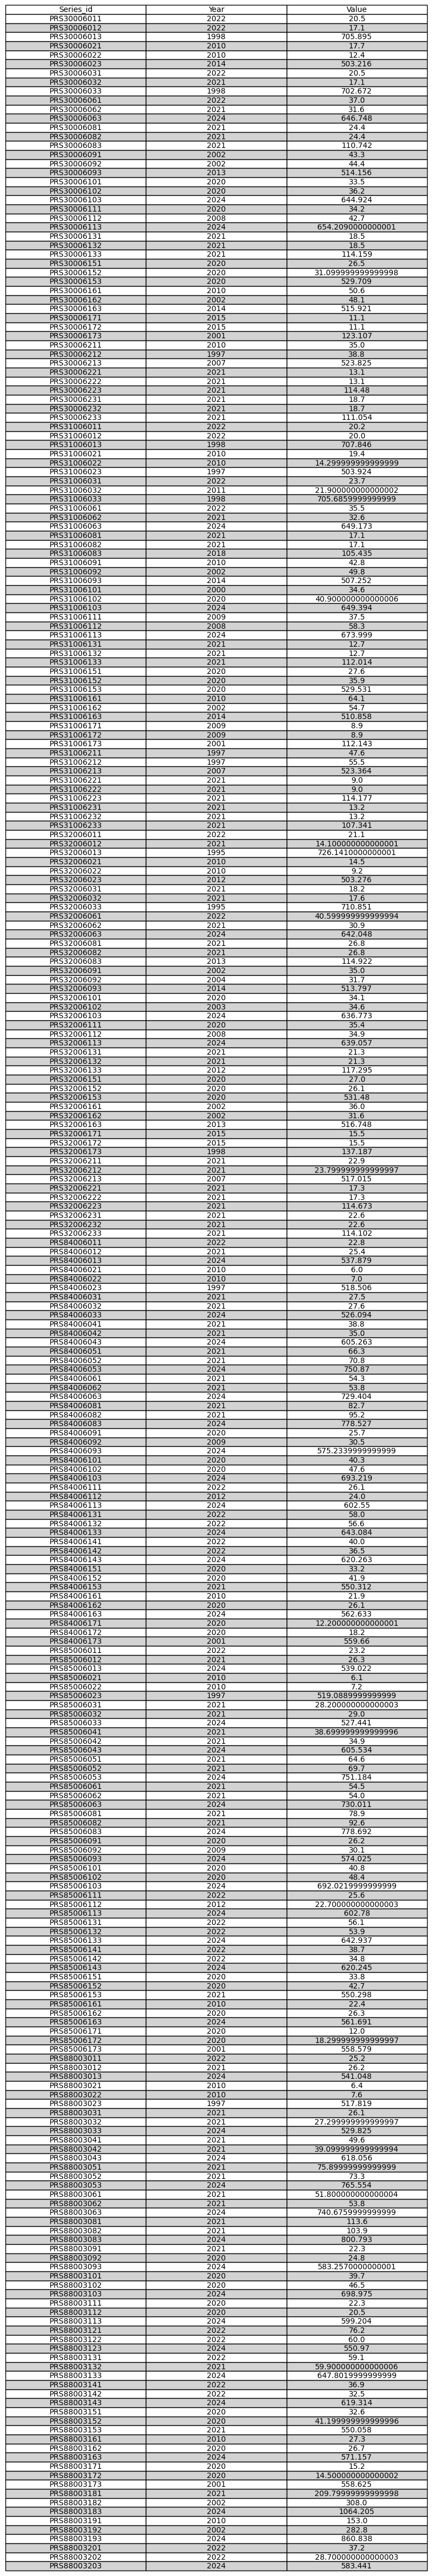

In [178]:
table_data = best_years_for_each_series.astype(str).values
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
table = ax.table(
    cellText=table_data.tolist(),
    colLabels=best_years_for_each_series.columns.tolist(),
    cellLoc='center',
    loc='center',
    ),

for i, cell in enumerate(table[0].get_celld().values()):
    num_cols = len(table_data[0])
    row_index = i // num_cols

    if row_index % 2 == 0:
        cell.set_facecolor("white")
    else:
        cell.set_facecolor("lightgrey")
plt.show()

In [179]:
series_PRS30006032_data = bls_df.loc[(bls_df["Series_id"] == "PRS30006032") & (bls_df["Period"] == "Q01")]

In [180]:
concatenated_df = series_PRS30006032_data.merge(population_df, on="Year", how="inner")
concatenated_df = concatenated_df.drop(columns=["Footnote_codes", "Nation ID", "Nation"])
concatenated_df = concatenated_df.rename(columns={"Value": "value", "Year": "year", "Series_id": "series", "Period": "period"})

## Series PRS30006032 Q1 Population Data

The below table was created by isolating the data for Q01 for the series PRS30006032 for each year in the BLS data. This was then merged with the population data to provide a dataframe that only included the rows where the population data is available.

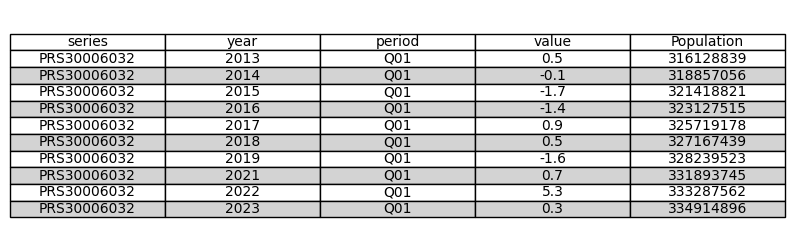

In [181]:
table_data = concatenated_df.astype(str).values
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("off")
table = ax.table(
    cellText=table_data.tolist(),
    colLabels=concatenated_df.columns.tolist(),
    cellLoc='center',
    loc='center',
    ),

for i, cell in enumerate(table[0].get_celld().values()):
    num_cols = len(table_data[0])
    row_index = i // num_cols

    if row_index % 2 == 0:
        cell.set_facecolor("white")
    else:
        cell.set_facecolor("lightgrey")
plt.show()